<a href="https://colab.research.google.com/github/TrungLeDangThanh/neural-networks-zero-to-hero/blob/main/The_spelled_out_intro_to_neural_networks_and_backpropagation_building_micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
class Value:
  def __init__(self, data, _children=(), _op="", label=""):
    self.data = data
    self.grad = 0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    output = Value(self.data + other.data, (self, other), "+")

    def _backward():
      self.grad += 1.0 * output.grad
      other.grad += 1.0 * output.grad

    output._backward = _backward
    return output

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    output = Value(self.data * other.data, (self, other), "*")

    def _backward():
      self.grad += other.data * output.grad
      other.grad += self.data * output.grad

    output._backward = _backward
    return output

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "Only supporting int/float powers for now"
    output = Value(self.data**other, (self,), f"**{other}")

    def _backward():
      self.grad += (other * self.data**(other-1)) * output.grad

    output._backward = _backward
    return output

  def __neg__(self):  # -a  # self = a
    return self * -1

  def __sub__(self, other):  # a - b  # self = a, other = b
    return self + (-other)

  def __truediv__(self, other):  # a / b  # self = a, other = b
    return self * other**-1

  def __radd__(self, other):  # b + a  # self = b, other = a
    return self + other

  def __rmul__(self, other):  # b * a  # self = b, other = a
    return self * other

  def __rsub__(self, other):  # (-b) + a  # self = b, other = a
    return (-self) + other

  def __rtruediv__(self, other):  # b**-1 * a  # self = b, other = a
    return self**-1 * other

  def exp(self):  # e to the power of x
    x = self.data
    output = Value(math.exp(x), (self, ), "exp")

    def _backward():
      self.grad += output.data * output.grad

    output._backward = _backward
    return output

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    output = Value(t, (self, ), "tanh")

    def _backward():
      self.grad += (1 - t**2) * output.grad

    output._backward = _backward
    return output

  def backward(self):
    topo = []
    visited = set()

    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)

    build_topo(self)
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# normalize function
o = n.tanh(); o.label = 'o'

In [ ]:
o.backward()

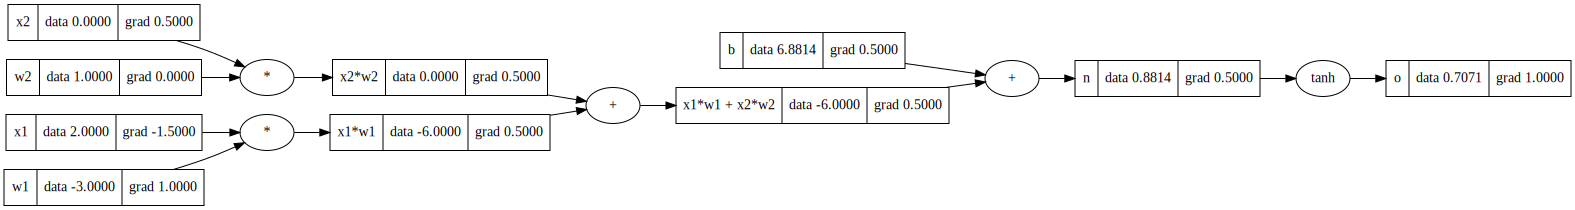

In [ ]:
draw_dot(o)

Value(data=11.666666666666666)


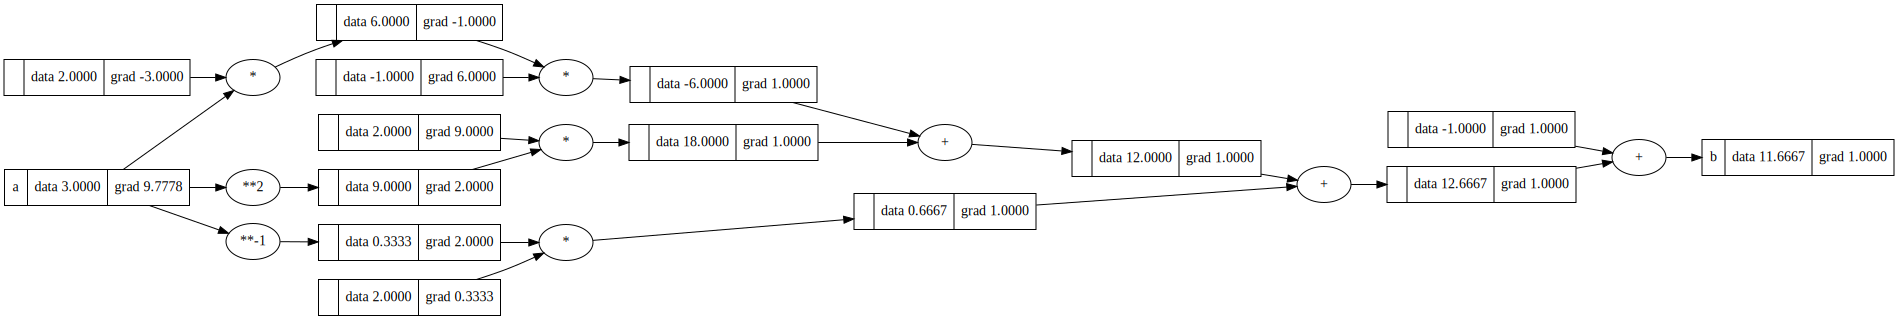

In [ ]:
a = Value(3.0, label='a')
b = 2*a**2 - 2*a + 2/a - 1   ; b.label = 'b'

print(b)
b.backward()
draw_dot(b)

In [ ]:
class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    # w * x + b
    activation = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
    output = activation.tanh()
    return output

  def parameters(self):
    params = self.w + [self.b]
    return params


class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outputs = [neuron(x) for neuron in self.neurons]
    return outputs

  def parameters(self):
    params = []
    for neuron in self.neurons:
      params += neuron.parameters()
    return params


class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    params = []
    for layer in self.layers:
      params += layer.parameters()
    return params

  @staticmethod
  def loss(ys, ypred):
    losses = []
    for ygt, yout in zip(ys, ypred):
      loss = sum((yout[i] - ygt[i])**2 for i in range(len(ygt)))
      losses.append(loss)

    loss = sum(loss for loss in losses) / len(losses)
    return loss

In [ ]:
x = [2, 3, -1]
n = MLP(3, [4, 4, 1])
n(x)

[Value(data=-0.08425336581125087)]

In [ ]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]  # inputs
ys = [
  [1.0, 1.0],
  [-1.0, -1.0],
  [-1.0, 1.0],
  [1.0, -1.0]
]  # desired outputs

n = MLP(3, [4, 4, 2])

ypred = [n(x) for x in xs]
ypred

[[Value(data=0.06677344858147563), Value(data=-0.9481316118796925)],
 [Value(data=-0.4486032568463987), Value(data=0.4860243288313295)],
 [Value(data=-0.44909342183136414), Value(data=0.868007249919563)],
 [Value(data=0.012600760419869602), Value(data=-0.9404336920776596)]]

In [ ]:
# losses = []
# for ygt, yout in zip(ys, ypred):
#   loss = sum((youti - ygti)**2 for ygti, youti in zip(ygt, yout))
#   losses.append(loss)
# print(losses)

# loss = sum(loss for loss in losses) / len(losses)
# print(loss)

In [ ]:
# losses = []
# for ygt, yout in zip(ys, ypred):
#   loss = sum((yout[i] - ygt[i])**2 for i in range(len(ygt)))
#   losses.append(loss)
# print(losses)

# loss = sum(loss for loss in losses) / len(losses)
# print(loss)

In [ ]:
loss = n.loss(ys, ypred)
print(loss)

Value(data=2.1194651987556683)


In [ ]:
loss.backward()

In [ ]:
print(n.layers[0].neurons[0].w[0].data)
print(n.layers[0].neurons[0].w[0].grad)

-0.1412773885506513
0.9590988882271618


In [ ]:
n.parameters()

[Value(data=-0.1412773885506513),
 Value(data=-0.03250125397667247),
 Value(data=0.6945452976486839),
 Value(data=0.47732338714286193),
 Value(data=-0.013593446955239452),
 Value(data=0.34615165525612723),
 Value(data=-0.6308405338313772),
 Value(data=-0.839233195784727),
 Value(data=-0.21782559435217808),
 Value(data=-0.7163927664377898),
 Value(data=0.9608919998557284),
 Value(data=0.9701334257440644),
 Value(data=-0.8349880427374956),
 Value(data=0.5668164831087896),
 Value(data=0.6439867716697147),
 Value(data=-0.6812677629947579),
 Value(data=0.02351024744635155),
 Value(data=0.27987167884015585),
 Value(data=-0.09364031685804575),
 Value(data=0.9524801884099185),
 Value(data=-0.09702247755542381),
 Value(data=-0.5586440308884204),
 Value(data=0.06793959930217763),
 Value(data=-0.8084440663908636),
 Value(data=-0.8380722311795052),
 Value(data=-0.07710733875900355),
 Value(data=-0.9522564329490735),
 Value(data=-0.29518331068483583),
 Value(data=-0.1219377553565375),
 Value(data=0

In [ ]:
step = 0.1
for param in n.parameters():
  param.data += -param.grad * step

In [ ]:
# # forward
# ypred = [n(x) for x in xs]
# loss = n.loss(ys, ypred)

# # backward
# for p in n.parameters():
#   p.grad = 0
# loss.backward()

# # update
# step = 1000
# for param in n.parameters():
#   param.data += -param.grad * step

In [ ]:
for _ in range(1000):
  # forward
  ypred = [n(x) for x in xs]
  loss = n.loss(ys, ypred)

  # backward
  for p in n.parameters():
    p.grad = 0
  loss.backward()

  # update
  step = 0.1
  for param in n.parameters():
    param.data += -param.grad * step

In [ ]:
ypred = [n(x) for x in xs]
n.loss(ys, ypred)

Value(data=0.0007853112970883494)

In [ ]:
ypred

[[Value(data=0.9825163009859068), Value(data=0.9770708448465069)],
 [Value(data=-0.9778434831228819), Value(data=-0.9815507741157826)],
 [Value(data=-0.9830534151158132), Value(data=0.9841056022869854)],
 [Value(data=0.9784856383380119), Value(data=-0.978186065242307)]]

In [ ]:
# import torch

In [ ]:
# x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
# x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
# w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
# w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
# b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
# n = x1*w1 + x2*w2 + b
# o = torch.tanh(n)

# print(o.data.item())
# o.backward()

# print('---')
# print('x2', x2.grad.item())
# print('w2', w2.grad.item())
# print('x1', x1.grad.item())
# print('w1', w1.grad.item())

In [ ]:
# print(o)
# print(o.data.item())
# print(o.item())

In [ ]:
# print(w1.grad)
# print(w1.grad.item())